# Assignment 2

Please access the CSMAR database and download the following data for all listed firms in the A-share market: 

(i) monthly Stock Closing Price, Return (without cash dividend reinvested) over Dec. 2009 to Dec. 2023 from Individual Stock Trading table, 

(ii) quarterly Return on Equity - TTM and Net Assets per Share over 2009Q3 to 2023Q4 from Financial Indicator table, 

(iii) daily stock volatility (of the log return of the lastest 250 trading days) at 2010/12/31 from Stock Market Derivative Index table. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


df_price_return = pd.read_csv('data/Price & Return/TRD_Mnth.csv')
df_volatility = pd.read_csv('data/Return Volatility/STK_MKT_STKBTAL.csv')
df_ROE_NAPS = pd.read_csv('data/ROE & NAPS/FI_T9(Merge Query).csv')

In [2]:
'''Initial data cleaning'''

# rename columns
df_price_return.rename(columns={'Stkcd': 'stock_code', 'Trdmnt': 'date', 'Mclsprc': 'monthly_price', 
                                'Mretnd': 'monthly_return'}, inplace=True)
df_volatility.rename(columns={'Symbol': 'stock_code', 'TradingDate': 'date', 'Volatility': 'volatility'}, inplace=True)
df_ROE_NAPS.rename(columns={'FI_T9.Stkcd': 'stock_code','FI_T9.Accper' : 'date', 'FI_T9.Typrep': 'type',
                            'FI_T9.F091001A': 'NAPS', 'FI_T5.F050504C': 'ROE'}, inplace=True)

# drop name columns
df_ROE_NAPS.drop(columns=['FI_T9.ShortName_EN', 'FI_T5.ShortName_EN'], inplace=True)

# delete type B in df_ROE_NAPS
df_ROE_NAPS = df_ROE_NAPS[df_ROE_NAPS['type'] != 'B']
df_ROE_NAPS.drop(columns=['type'], inplace=True)

In [3]:
'''Time manipulation & Merge'''

# change 2010-09 in df_ROE_NAPS into 2009-11 (12 later)
df_ROE_NAPS.loc[df_ROE_NAPS['date'] == '2009-09-30', 'date'] = '2009-11-01'

# change date to period
df_price_return['date'] = pd.to_datetime(df_price_return['date']).dt.to_period('M')
df_ROE_NAPS['date'] = pd.to_datetime(df_ROE_NAPS['date']).dt.to_period('M')
df_ROE_NAPS['date'] = (df_ROE_NAPS['date'].dt.to_timestamp() + pd.DateOffset(months=1)).dt.to_period('M')
df_volatility['date'] = pd.to_datetime(df_volatility['date']).dt.to_period('M')


merged_df = pd.merge(df_price_return, df_ROE_NAPS, on=['stock_code', 'date'], how='left')
merged_df = pd.merge(merged_df, df_volatility, on=['stock_code', 'date'], how='left')
merged_df['ROE'] = merged_df.groupby('stock_code')['ROE'].ffill()
merged_df['NAPS'] = merged_df.groupby('stock_code')['NAPS'].ffill()

Then derive monthly P/B ratios for all A-share stocks from Jan. 2010 to Dec. 2023. Exclude records with P/B ratios less than P/B ratio’s 5th percentile or greater than P/B ratio’s 95th percentile.

In [4]:
# Calculate P/B ratio
merged_df['PB'] = merged_df['monthly_price'] / merged_df['NAPS']

# Exclude records with P/B ratios less than 5th percentile or greater than 95th percentile
pb_5pct = merged_df['PB'].quantile(0.05)
pb_95pct = merged_df['PB'].quantile(0.95)
merged_df = merged_df[(merged_df['PB'] > pb_5pct) & (merged_df['PB'] < pb_95pct)]

merged_df.rename(columns={'date': 'month'}, inplace=True)
df_2009 = merged_df[merged_df['month'] == '2009-12']
merged_df = merged_df[merged_df['month'] != '2009-12']

### Question 1

Focusing on the observations for all A-share firms at the end of 2010, regress the P/B ratio at Dec. 2010 on Return on Equity - TTM (ROE) at 2010Q4 and Stock Volatility at 2010/12/31, i.e., you estimate the following cross-sectional regression:

P/B i = α + β 1 ROE i + β 2 Stock Volatility i + ϵ i .

Report regression results and discuss your findings.

In [5]:
# use the data of 2010-12
df_2010Q4 = merged_df[merged_df['month'] == '2010-12']

# drop missing values in PB, ROE, volatility
df_2010Q4.dropna(subset=['PB', 'ROE', 'volatility'], inplace=True)

# regress the P/B ratio at Dec 2010 on ROE at 2010Q4 and Stock Volatility at 2010-12
Y = df_2010Q4['PB']
X = df_2010Q4[['ROE', 'volatility']]
X = sm.add_constant(X)

# OLS regression
model = sm.OLS(Y, X)
results = model.fit()

# print and save the results as txt
print(results.summary())
with open('q1_result.txt', 'w') as f:
    f.write(results.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:                     PB   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     106.2
Date:                Fri, 19 Apr 2024   Prob (F-statistic):           1.23e-43
Time:                        03:09:41   Log-Likelihood:                -2864.5
No. Observations:                1385   AIC:                             5735.
Df Residuals:                    1382   BIC:                             5751.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1406      0.287      0.490      0.6

/var/folders/mw/z4y5_k0n393c13fcqpv2ms8m0000gn/T/ipykernel_44940/1932695291.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2010Q4.dropna(subset=['PB', 'ROE', 'volatility'], inplace=True)


### Question 2

For each month from Jan. 2010 to Dec. 2023, sort firms based on their last-month P/B ratios and divide firms into ten groups according to last-month P/B ratio deciles. 


In [6]:
# merge the data of 2009 into merged_df by merging df_2009
merged_df = pd.concat([merged_df, df_2009])

# sort firms based on their last-month P/B ratios
merged_df = merged_df.dropna(subset=['PB'])
merged_df['last_month_PB'] = merged_df.groupby('stock_code')['PB'].shift(1)
merged_df = merged_df.dropna(subset=['last_month_PB'])

sorted_df = merged_df.groupby('month').apply(lambda x: x.sort_values('last_month_PB')).reset_index(drop=True)

In [7]:
def sort_pb(group):
    group.sort_values('last_month_PB', inplace=True)
    return group


# divide firms into ten groups according to last-month P/B ratio deciles, for each month respectively as a group
sorted_df = sorted_df.groupby('month').apply(sort_pb).reset_index(drop=True)
sorted_df['decile'] = sorted_df.groupby('month')['last_month_PB'].transform(lambda x: pd.qcut(x, 10, labels=False))
sorted_df['decile'] = sorted_df['decile'] + 1

By holding all stocks within each group with equal weights and rebalancing positions every month, we can construct ten portfolios. Please calculate the monthly returns for the ten portfolios and use a bar chart to illustrate average returns for the ten portfolios from Jan. 2010 to Dec. 2023, and discuss your findings.

In [8]:
# calculate the average return of each decile in each month
decile_return = sorted_df.groupby(['month', 'decile'])['monthly_return'].mean().reset_index()

# calculate the average return of each decile in all months
decile_retur_all = decile_return.groupby('decile')['monthly_return'].mean().reset_index()

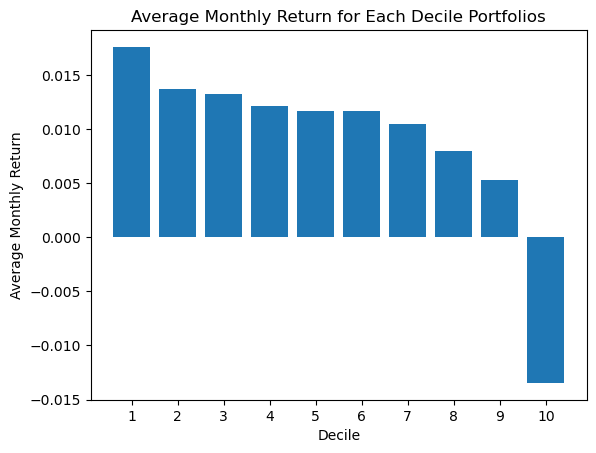

In [9]:
# use a bar chart to illustrate average returns for the ten portfolios from Jan. 2010 to Dec. 2023
plt.bar(decile_retur_all['decile'], decile_retur_all['monthly_return'])
plt.xlabel('Decile')
plt.ylabel('Average Monthly Return')
plt.title('Average Monthly Return for Each Decile Portfolios')
plt.xticks(range(1, 11))

# show and save the graph
plt.savefig('q2_graph.png', dpi=300)
plt.show()

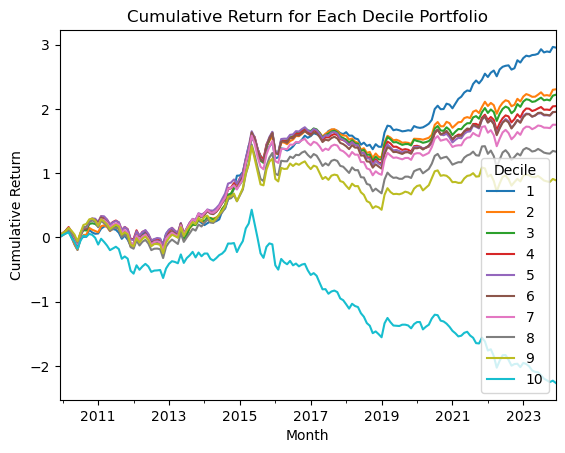

In [10]:
# show cumulative returns for each decile portfolio from Jan. 2010 to Dec. 2023
decile_return['cumulative_return'] = decile_return.groupby('decile')['monthly_return'].cumsum()
decile_return = decile_return.pivot(index='month', columns='decile', values='cumulative_return')
decile_return.plot()
plt.xlabel('Month')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return for Each Decile Portfolio')
plt.legend(title='Decile')
plt.show()
